<a href="https://colab.research.google.com/github/lemonyun/keras_study/blob/main/8_2_deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.8.0'

# 딥드림

In [2]:
from keras.applications import inception_v3
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


컨브넷 필터 시각화 기법과 비슷함 조금다름
딥드림 알고리즘은 특정 필터가 아니라 전체 층의 활성화를 최대화 함

그 다음 손실을 계산합니다. 경사 상승법으로 최대화할 값입니다. 5장 필터 시각화에서 특정 층의 필터 값을 최대화했습니다. 여기에서는 여러 층에 있는 모든 필터 활성화를 동시에 최대화합니다. 특별히 상위 층에 있는 활성화의 L2 노름에 대한 가중치 합을 최대화하겠습니다. 정확히 어떤 층들을 선택했는지에 따라 (당연히 최종 손실에 기여한 정도에 따라) 만들어 내는 시각 요소에 큰 영향을 미칩니다. 어떤 층을 선택할지 파라미터로 손쉽게 바꿀 수 있어야 좋습니다. 하위 층은 기하학적인 패턴을 만들고 상위 층은 ImageNet에 있는 클래스로 보이는 시각 요소를 만듭니다(예를 들어 새나 강아지). 먼저 임의로 네 개의 층을 선택해 보겠습니다. 나중에 다른 설정을 다양하게 시도해 보는 것이 좋습니다:

In [3]:
# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정합니다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

이제 손실 텐서를 정의하겠습니다. 위에서 선택한 층의 활성화에 대한 L2 노름의 가중치 합입니다.

In [11]:
# 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻습니다
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling # 층이 여러개이기 때문에 층마다 활성화의 크기가 다르기 때문에 정규화를 위해 전체 원소의 개수를 계산
    print(activation)
    print(scaling)
    print(loss)
    

Tensor("mixed2/concat:0", shape=(None, None, None, 288), dtype=float32)
Tensor("Prod_20:0", shape=(), dtype=float32)
Tensor("add_20:0", shape=(), dtype=float32)
Tensor("mixed3/concat:0", shape=(None, None, None, 768), dtype=float32)
Tensor("Prod_21:0", shape=(), dtype=float32)
Tensor("add_21:0", shape=(), dtype=float32)
Tensor("mixed4/concat:0", shape=(None, None, None, 768), dtype=float32)
Tensor("Prod_22:0", shape=(), dtype=float32)
Tensor("add_22:0", shape=(), dtype=float32)
Tensor("mixed5/concat:0", shape=(None, None, None, 768), dtype=float32)
Tensor("Prod_23:0", shape=(), dtype=float32)
Tensor("add_23:0", shape=(), dtype=float32)


In [5]:
# 이 텐서는 생성된 딥드림 이미지를 저장합니다
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산합니다
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화합니다(이 기교가 중요합니다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만듭니다
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [6]:
grads.shape

TensorShape([None, None, None, 3])

In [12]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = './gdrive/MyDrive/datasets/original_photo_deep_dream.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./final_dream.png')

처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.65961766
... 1 번째 손실 : 1.0167829
... 2 번째 손실 : 1.4680848
... 3 번째 손실 : 2.004861
... 4 번째 손실 : 2.612432
... 5 번째 손실 : 3.0967333
... 6 번째 손실 : 3.5739532
... 7 번째 손실 : 4.0591106
... 8 번째 손실 : 4.454108
... 9 번째 손실 : 4.8672996
... 10 번째 손실 : 5.227928
... 11 번째 손실 : 5.6588464
... 12 번째 손실 : 6.110178
... 13 번째 손실 : 6.413991
... 14 번째 손실 : 6.7856126
... 15 번째 손실 : 7.165495
... 16 번째 손실 : 7.6409826
... 17 번째 손실 : 7.9553394
... 18 번째 손실 : 8.318021
... 19 번째 손실 : 8.703764
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.1846814
... 1 번째 손실 : 3.5089548
... 2 번째 손실 : 4.6323223
... 3 번째 손실 : 5.6063213
... 4 번째 손실 : 6.5383105
... 5 번째 손실 : 7.2663193
... 6 번째 손실 : 8.149549
... 7 번째 손실 : 8.936064
... 8 번째 손실 : 9.642848
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.378679
... 1 번째 손실 : 3.8011065
... 2 번째 손실 : 5.2748404
... 3 번째 손실 : 7.097479
... 4 번째 손실 : 9.702336


In [19]:
from matplotlib import pyplot as plt

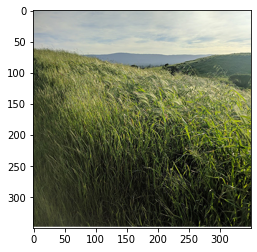

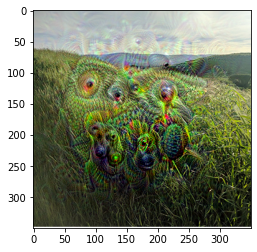

In [20]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()